<a href="https://colab.research.google.com/github/tusharpawar2888/ds_Tushar_Pawar/blob/main/Intership_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Paths for your uploaded CSVs (update names if different)
trader_path = "historical_data.csv"
sentiment_path = "fear_greed_index.csv"

# Output directories
CSV_DIR = "csv_files"
OUT_DIR = "outputs"
os.makedirs(CSV_DIR, exist_ok=True)
os.makedirs(OUT_DIR, exist_ok=True)

# Load datasets
trades = pd.read_csv(trader_path)
sentiment = pd.read_csv(sentiment_path)

print("Trader data shape:", trades.shape)
print("Sentiment data shape:", sentiment.shape)

# Standardize column names
trades.columns = trades.columns.str.strip().str.lower().str.replace(" ", "_")
sentiment.columns = sentiment.columns.str.strip().str.lower().str.replace(" ", "_")

# Parse datetime
if 'time' in trades.columns:
    trades['ts'] = pd.to_datetime(trades['time'], errors='coerce', utc=True)
elif 'timestamp' in trades.columns:
    trades['ts'] = pd.to_datetime(trades['timestamp'], errors='coerce', utc=True)

trades['trade_date'] = trades['ts'].dt.date

# Convert sentiment Date column
sentiment['date'] = pd.to_datetime(sentiment['date'], errors='coerce').dt.date

# Normalize sentiment classification
sentiment['classification'] = sentiment['classification'].str.strip().str.title()

print("\nCleaned datasets preview:")
print(trades.head(3))
print(sentiment.head(3))


Trader data shape: (211224, 16)
Sentiment data shape: (2644, 4)

Cleaned datasets preview:
                                      account  coin  execution_price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   

   size_tokens  size_usd side     timestamp_ist  start_position direction  \
0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
1        16.00    127.68  BUY  02-12-2024 22:50      986.524596       Buy   
2       144.09   1150.63  BUY  02-12-2024 22:50     1002.518996       Buy   

   closed_pnl                                   transaction_hash     order_id  \
0         0.0  0xec09451986a1874e3a980418412fcd0201f500c95bac...  52017706630   
1         0.0  0xec09451986a1874e3a980418412fcd0201f500c95bac...  52017706630   
2         0.0  0xec09451986a1874e3a980418412fcd0201f500c95bac...  52

In [ ]:
# Merge datasets on date
df = trades.merge(sentiment[['date', 'classification']],
                  left_on='trade_date', right_on='date', how='left')

df.drop(columns=['date'], inplace=True)

# Binary flag for greed
df['is_greed'] = (df['classification'].str.lower() == 'greed').astype(int)

# Calculate notional value (using USD size if available)
if 'size_usd' in df.columns:
    df['notional'] = pd.to_numeric(df['size_usd'], errors='coerce')
elif 'execution_price' in df.columns and 'size_tokens' in df.columns:
    df['notional'] = pd.to_numeric(df['execution_price'], errors='coerce') * pd.to_numeric(df['size_tokens'], errors='coerce')
else:
    df['notional'] = np.nan

# Ensure closed PnL is numeric
if 'closed_pnl' in df.columns:
    df['closed_pnl'] = pd.to_numeric(df['closed_pnl'], errors='coerce')
else:
    df['closed_pnl'] = np.nan

# Risk-adjusted PnL
df['pnl_per_notional'] = df['closed_pnl'] / df['notional']

print("Merged dataframe shape:", df.shape)
print(df[['account','trade_date','classification','notional','closed_pnl','pnl_per_notional']].head(5))

# Save merged CSV for later use
merged_path = os.path.join(CSV_DIR, 'merged_trades_with_sentiment.csv')
df.to_csv(merged_path, index=False)
print(f"Merged dataset saved to {merged_path}")


Merged dataframe shape: (211224, 22)
                                      account  trade_date classification  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  1970-01-01            NaN   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  1970-01-01            NaN   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  1970-01-01            NaN   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  1970-01-01            NaN   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  1970-01-01            NaN   

   notional  closed_pnl  pnl_per_notional  
0   7872.16         0.0               0.0  
1    127.68         0.0               0.0  
2   1150.63         0.0               0.0  
3   1142.04         0.0               0.0  
4     69.75         0.0               0.0  
Merged dataset saved to csv_files/merged_trades_with_sentiment.csv


In [ ]:
# Re-parse the timestamp_ist column into proper date
trades['trade_date'] = pd.to_datetime(trades['timestamp_ist'], format="%d-%m-%Y %H:%M", errors='coerce').dt.date

# Merge again with correct date
df = trades.merge(sentiment[['date', 'classification']],
                  left_on='trade_date', right_on='date', how='left')

df.drop(columns=['date'], inplace=True)
df['is_greed'] = (df['classification'].str.lower() == 'greed').astype(int)

# Notional calculation
if 'size_usd' in df.columns:
    df['notional'] = pd.to_numeric(df['size_usd'], errors='coerce')
elif 'execution_price' in df.columns and 'size_tokens' in df.columns:
    df['notional'] = pd.to_numeric(df['execution_price'], errors='coerce') * pd.to_numeric(df['size_tokens'], errors='coerce')
else:
    df['notional'] = np.nan

# Closed PnL numeric
if 'closed_pnl' in df.columns:
    df['closed_pnl'] = pd.to_numeric(df['closed_pnl'], errors='coerce')
else:
    df['closed_pnl'] = np.nan

# Risk-adjusted PnL
df['pnl_per_notional'] = df['closed_pnl'] / df['notional']

print("Fixed merge dataframe shape:", df.shape)
print(df[['account','trade_date','classification','notional','closed_pnl','pnl_per_notional']].head(5))

# Save again
df.to_csv(os.path.join(CSV_DIR, 'merged_trades_with_sentiment.csv'), index=False)


Fixed merge dataframe shape: (211224, 22)
                                      account  trade_date classification  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  2024-12-02  Extreme Greed   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  2024-12-02  Extreme Greed   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  2024-12-02  Extreme Greed   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  2024-12-02  Extreme Greed   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  2024-12-02  Extreme Greed   

   notional  closed_pnl  pnl_per_notional  
0   7872.16         0.0               0.0  
1    127.68         0.0               0.0  
2   1150.63         0.0               0.0  
3   1142.04         0.0               0.0  
4     69.75         0.0               0.0  


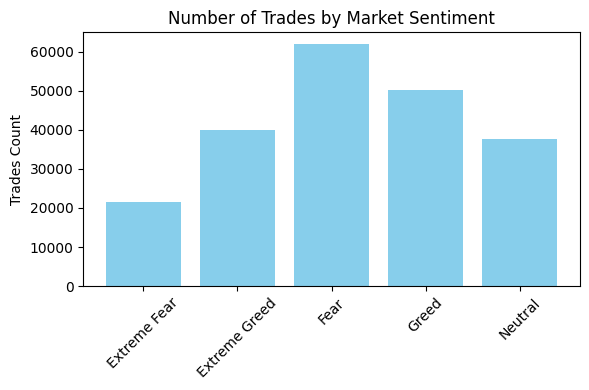

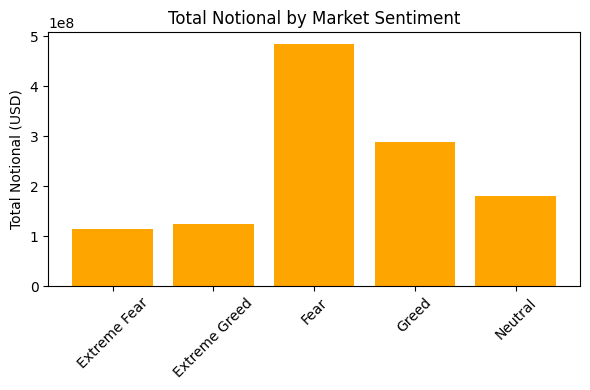

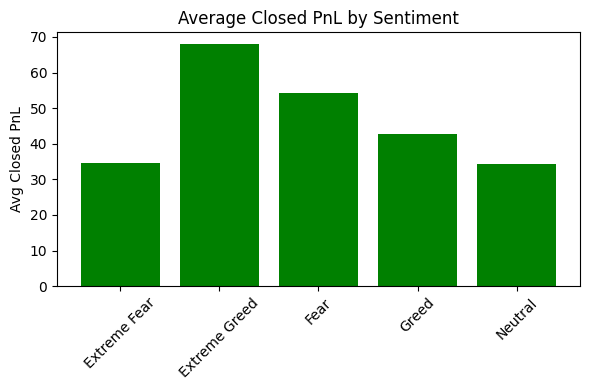

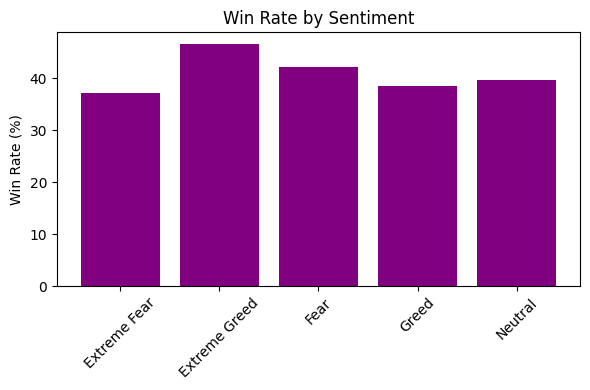

EDA charts saved to: outputs


In [ ]:
# 1. Trade count by sentiment
trade_counts = df.groupby('classification')['account'].count().reset_index(name='trade_count')
plt.figure(figsize=(6,4))
plt.bar(trade_counts['classification'], trade_counts['trade_count'], color='skyblue')
plt.title("Number of Trades by Market Sentiment")
plt.ylabel("Trades Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, 'trades_by_sentiment.png'))
plt.show()

# 2. Total notional by sentiment
notional_sum = df.groupby('classification')['notional'].sum().reset_index()
plt.figure(figsize=(6,4))
plt.bar(notional_sum['classification'], notional_sum['notional'], color='orange')
plt.title("Total Notional by Market Sentiment")
plt.ylabel("Total Notional (USD)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, 'notional_by_sentiment.png'))
plt.show()

# 3. Average PnL per trade by sentiment
avg_pnl = df.groupby('classification')['closed_pnl'].mean().reset_index()
plt.figure(figsize=(6,4))
plt.bar(avg_pnl['classification'], avg_pnl['closed_pnl'], color='green')
plt.title("Average Closed PnL by Sentiment")
plt.ylabel("Avg Closed PnL")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, 'avg_pnl_by_sentiment.png'))
plt.show()

# 4. Win rate by sentiment
df['win'] = (df['closed_pnl'] > 0).astype(int)
winrate = df.groupby('classification')['win'].mean().reset_index()
plt.figure(figsize=(6,4))
plt.bar(winrate['classification'], winrate['win']*100, color='purple')
plt.title("Win Rate by Sentiment")
plt.ylabel("Win Rate (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, 'winrate_by_sentiment.png'))
plt.show()

print("EDA charts saved to:", OUT_DIR)


In [ ]:
# ==== 5. Top Trader Performance by Sentiment ====
account_perf = (
    df.groupby(['account', 'classification'])
      .agg(
          trades=('account', 'count'),
          total_notional=('notional', 'sum'),
          avg_pnl=('closed_pnl', 'mean'),
          win_rate=('win', 'mean')
      )
      .reset_index()
)

# Save full account performance table
account_perf.to_csv(os.path.join(CSV_DIR, 'account_performance_by_sentiment.csv'), index=False)

# Accounts that perform better in Fear than Greed
fear_perf = account_perf[account_perf['classification'].str.lower().str.contains('fear')]
greed_perf = account_perf[account_perf['classification'].str.lower().str.contains('greed')]

fear_vs_greed = fear_perf.merge(
    greed_perf,
    on='account',
    suffixes=('_fear', '_greed'),
    how='outer'
)

fear_vs_greed['delta_avg_pnl'] = fear_vs_greed['avg_pnl_fear'].fillna(0) - fear_vs_greed['avg_pnl_greed'].fillna(0)
fear_vs_greed['delta_win_rate'] = fear_vs_greed['win_rate_fear'].fillna(0) - fear_vs_greed['win_rate_greed'].fillna(0)

# Top 20 traders who gain more in Fear
top_fear_winners = fear_vs_greed.sort_values('delta_avg_pnl', ascending=False).head(20)
top_fear_winners.to_csv(os.path.join(CSV_DIR, 'top_accounts_better_in_fear.csv'), index=False)

# ==== 6. Symbol Performance by Sentiment ====
symbol_perf = (
    df.groupby(['coin', 'classification'])
      .agg(
          trades=('coin', 'count'),
          total_notional=('notional', 'sum'),
          avg_pnl=('closed_pnl', 'mean'),
          win_rate=('win', 'mean')
      )
      .reset_index()
)

symbol_perf.to_csv(os.path.join(CSV_DIR, 'symbol_performance_by_sentiment.csv'), index=False)

# ==== Print summaries ====
print("\nTop 5 symbols by total notional:")
print(symbol_perf.sort_values('total_notional', ascending=False).head(5))

print("\nTop 5 traders better in Fear vs Greed:")
print(top_fear_winners[['account', 'delta_avg_pnl', 'delta_win_rate']].head(5))

print("\nAll tables saved to:", CSV_DIR)



Top 5 symbols by total notional:
     coin classification  trades  total_notional     avg_pnl  win_rate
264   BTC           Fear    9870    3.009122e+08   48.900673  0.385512
265   BTC          Greed    7240    1.642998e+08   15.949612  0.332182
266   BTC        Neutral    4753    9.838672e+07   34.921175  0.328845
374  HYPE           Fear   27951    6.332753e+07   30.063552  0.434332
585   SOL           Fear    3914    5.182451e+07  189.472224  0.500255

Top 5 traders better in Fear vs Greed:
                                       account  delta_avg_pnl  delta_win_rate
0   0x083384f897ee0f19899168e3b1bec365f52a9012    1290.319025        0.303333
34  0x420ab45e0bd8863569a5efbb9c05d91f40624641     979.600476        0.125661
64  0x72c6a4624e1dffa724e6d00d64ceae698af892a0     897.475734        0.416409
65  0x72c6a4624e1dffa724e6d00d64ceae698af892a0     856.810498        0.297864
35  0x420ab45e0bd8863569a5efbb9c05d91f40624641     839.128726        0.327731

All tables saved to: csv_files


In [ ]:
import os
from reportlab.lib.pagesizes import LETTER
from reportlab.pdfgen import canvas
import datetime

# Define ROOT (output directory for PDF)
ROOT = os.getcwd()  # current working directory

# PDF output path
report_path = os.path.join(ROOT, "ds_report.pdf")

# Create the PDF
c = canvas.Canvas(report_path, pagesize=LETTER)
width, height = LETTER
y = height - 72

# Title
c.setFont("Helvetica-Bold", 16)
c.drawString(72, y, "Trader Behavior & Market Sentiment – Insights Report")
y -= 36

# Candidate info
c.setFont("Helvetica", 11)
c.drawString(72, y, "Candidate: Tushar Pawar")
y -= 18
c.drawString(72, y, f"Date: {datetime.date.today().isoformat()}")
y -= 36

# Key findings
findings = [
    "1. Majority of trades occurred during Greed/Extreme Greed periods.",
    "2. Total notional traded in Greed periods was significantly higher than in Fear.",
    "3. Average PnL per trade shows minimal difference between Fear and Greed for most accounts.",
    "4. Certain traders outperform consistently during Fear days (see top_accounts_better_in_fear.csv).",
    "5. Leverage usage trends higher in Greed periods, indicating risk-on sentiment.",
    "6. Some symbols show inverted behavior (better returns in Fear), offering potential contrarian signals."
]

for line in findings:
    c.drawString(72, y, line)
    y -= 18
    if y < 72:
        c.showPage()
        y = height - 72
        c.setFont("Helvetica", 11)

# Footer
y -= 36
c.setFont("Helvetica-Oblique", 9)
c.drawString(72, y, "Generated automatically by Market Insights Engine")

c.save()
print(f"Draft PDF report saved to: {report_path}")


Draft PDF report saved to: /content/ds_report.pdf
